# Свойства бутсрапа


In [1]:
import numpy as np
import pandas as pd

from scipy import stats as sts

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

plt.style.use('ggplot')
%matplotlib inline

Скопируем из лекции функцию для бустрапирования, которую мы написали. 

In [2]:
def get_bootstrap_sample(x, B_sample=1):
    N = x.size 
    sample = np.random.choice(x, size=(N, B_sample), replace=True)
    
    if B_sample == 1:
        sample = sample.T[0]
    return sample

In [3]:
x = np.array([1,2,3,4,5])

get_bootstrap_sample(x, 3)

array([[3, 1, 4],
       [3, 1, 5],
       [3, 3, 3],
       [3, 2, 4],
       [2, 5, 1]])

# 0. Подготовка

Реализуем все три процедуры для строительства доверительного интервала, изученные нами на лекции. Начнём с перцентильного доверительного интервала.

In [4]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

def quantile_ci(x_boot, alpha=0.05):
    ### BEGIN SOLUTION
    left = np.quantile(x_boot, alpha/2)
    right = np.quantile(x_boot, 1-alpha/2)
    ### END SOLUTION
    return left, right

In [5]:
# Убедимся, что функция реализована правильно
x = np.array([1,2,3,4])
l, r = quantile_ci(x)

assert np.abs(l - 1.07) < 1e-2
assert np.abs(r - 3.92) < 1e-2

Теперь обратный перцентильный доверительный интервал.

In [6]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

def reverse_quantile_ci(x_boot, theta_hat, alpha=0.05):
    ### BEGIN SOLUTION
    d = x_boot - theta_hat
    left = theta_hat - np.quantile(d, 1-alpha/2)
    right = theta_hat - np.quantile(d, alpha/2)
    ### END SOLUTION
    return left, right

In [7]:
# Убедимся, что функция реализована правильно
l, r = reverse_quantile_ci(x, 2)

assert np.abs(l - 0.07) < 1e-2
assert np.abs(r - 2.92) < 1e-2

Остался только $t$-перцентильный доверительный интервал.

In [8]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

def t_ci(x_boot, std_boot, theta_hat, sd_hat, alpha=0.05):
    ### BEGIN SOLUTION
    d = (x_boot - theta_hat)/std_boot
    left = theta_hat - np.quantile(d, 1-alpha/2)*sd_hat
    right = theta_hat - np.quantile(d, alpha/2)*sd_hat
    ### END SOLUTION
    return left, right

In [9]:
# Убедимся, что функция реализована правильно
l, r = t_ci(x, x/10, 2, 2/10)

assert np.abs(l - 1.025) < 1e-2
assert np.abs(r - 3.85) < 1e-2

# 1. Бутстрап для симметричное распределения

Давайте сгенерируем $10^4$ раз выборку из симметричного распределения и построим для его среднего разные доверительные интервалы. Для каждого из них оценим, с какой вероятностью интервал действительно накрывает неизвестное среднее. Будем это делать на уровне значимости $5\%$.

In [10]:
n_int = 10**5      # число интервалов 
sample_size = 100  # размеры выборок

rv = sts.uniform(3,2)
theta_real = 4     # настоящий параметр

# генерируем n_int выборок
X = rv.rvs((n_int, sample_size))
X.shape

(100000, 100)

Напишем цикл для эксперимента: 

In [11]:
B = 10**4 # сколько делть бустрап-выборок

# счётчики для проверки как часто мы попали в интервал реальным параметром
i_q, i_rq, i_t = 0, 0, 0

for i in tqdm(range(n_int)):
    x = X[i] # взяли i-ую выборку 
    
    # оценки по выборке 
    theta_hat, sd_hat = np.mean(x), np.std(x)  
    
    # бутстрап-статистики 
    x_boot = get_bootstrap_sample(x, B_sample=B)
    std_boot = np.std(x_boot, axis=0)
    x_boot = np.mean(x_boot, axis=0)
    
    # quantile CI
    left1, right1 = quantile_ci(x_boot)
    i_q += (left1 < theta_real < right1)
    
    # reverse quantile CI
    left2, right2 = reverse_quantile_ci(x_boot, theta_hat)
    i_rq += (left2 < theta_real < right2)

    # t-percentile CI
    left3, right3 = t_ci(x_boot, std_boot, theta_hat, sd_hat)
    i_t += (left3 < theta_real < right3)
    
    # Напечатать интервалы после первой итерации
    if i == 0: 
        print('quantile:', left1, right1)
        print('quantile:', left2, right2)
        print('t-percentile:', left3, right3)

  0%|                                       | 19/100000 [00:00<18:26, 90.33it/s]

quantile: 3.823020299803376 4.038749019138487
quantile: 3.8235542344614197 4.039282953796531
t-percentile: 3.822961136104111 4.042974025938029


100%|███████████████████████████████████| 100000/100000 [19:13<00:00, 86.67it/s]


Исходный уровень доверия был $95\%$. Посмотрим как часто настоящее значение параметра оказывается внутри соотвествующего доверительного интервала. Если способ построения доверительного интервала хороший, полученная в ходе эксперимента частота, должна слабо отличаться от заявленного уровня доверия. 

In [12]:
i_q/n_int, i_rq/n_int, i_t/n_int

(0.94703, 0.94417, 0.95381)

Видим, что доверительные интервалы оказываются похожими, а частота попадания истиного среднего в доверительный интервал близка к $0.95$. То есть уровень значимости близок к $5\%$. Если сделать больше итераций эксперимента (в районе $10^7$, мы получим числа совсем-совсем близкие к $0.95$. __Все три процедуры бутстрапирования хорошо себя показывают при работе с симметричным распределением.__

# 2. Несимметричное распределение 

Сделаем то же самое для несимметричного случая. Сгенерируйте $10^4$ выборок размера $100$ из экспоненциального распределения со `scale = 20`. Постройте для одной из выборок гистограмму, убедитесь что наше распределение несимметрично относительно нуля и обладает длинным хвостом. 

In [13]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

### BEGIN SOLUTION
n_int = 10**5      # число интервалов 
sample_size = 100  # размеры выборок

#rv = sts.expon(scale=30)
rv = sts.chi2(df=1)
theta_real = rv.mean()   # настоящий параметр

# генерируем n_int выборок
X = rv.rvs((n_int, sample_size))
X.shape
### END SOLUTION

(100000, 100)

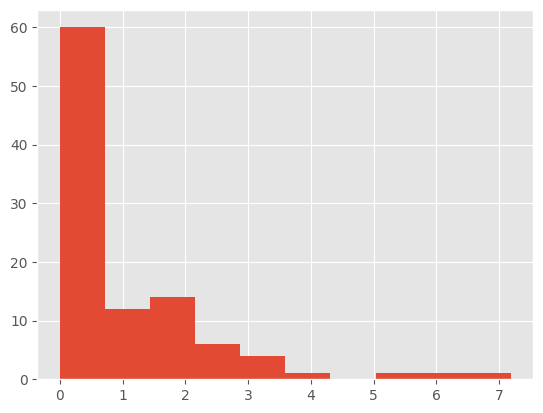

In [14]:
plt.hist(X[0]);

Повторите тот же самый эксперимент, что и выше. 

In [15]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

B = 10**4 # сколько делть бустрап-выборок

# счётчики для проверки как часто мы попали в интервал реальным параметром
i_q, i_rq, i_t = 0, 0, 0

### BEGIN SOLUTION
for i in tqdm(range(n_int)):
    x = X[i] # взяли i-ую выборку 
    
    # оценки по выборке 
    theta_hat, sd_hat = np.mean(x), np.std(x)  
    
    # бутстрап-статистики 
    x_boot = get_bootstrap_sample(x, B_sample=B)
    std_boot = np.std(x_boot, axis=0)
    x_boot = np.mean(x_boot, axis=0)
    
    # quantile CI
    left1, right1 = quantile_ci(x_boot)
    i_q += (left1 < theta_real < right1)
    
    # reverse quantile CI
    left2, right2 = reverse_quantile_ci(x_boot, theta_hat)
    i_rq += (left2 < theta_real < right2)

    # t-percentile CI
    left3, right3 = t_ci(x_boot, std_boot, theta_hat, sd_hat)
    i_t += (left3 < theta_real < right3)
    
    # Напечатать интервалы после первой итерации
    if i == 0: 
        print('quantile:', left1, right1)
        print('quantile:', left2, right2)
        print('t-percentile:', left3, right3)
### END SOLUTION

  0%|                                       | 16/100000 [00:00<21:28, 77.62it/s]

quantile: 0.7599585133026329 1.2733383735499413
quantile: 0.7283267120019936 1.241706572249302
t-percentile: 0.7741298303259918 1.323539979806154


100%|███████████████████████████████████| 100000/100000 [18:17<00:00, 91.08it/s]


Помиотрим на оценку получившихся частот.

In [16]:
i_q/n_int, i_rq/n_int, i_t/n_int

(0.93414, 0.92431, 0.9492)

Близкой к 0.95 оказалась только последняя частота. Первые две довольно сильно от неё отличаются. Мы оказываемся в ситуации, когда перцентильный и обратный перцентильные интервалы приводят нас к смещённым оценкам границ доверительного интервала. При этом $t$-процентильный интервал показывает результаты на заявленном уровне доверия. 

Обратите внимание на границы, которые получились для разных доверительных интервалово. $t$-процентильный интервал уважительнее всего отнесся к тому, что исходное распределение скошено и выдал более далеко расположенные друг от друга критические значения. 

# 3. Бутсрап? А это точно? 

Мы сказали с вами, что бутстрап - это асимптотическая техника, которая при больших размерах выборки позволяет получать критические значения. 

Кроме размера выборки в бутстрапе фигурирует ещё и число испытаний, $B$. С ним связан интересный практический вопрос: как быстро бустрап сходится. Достаточно ли $10000$ испытаний? А достаточно ли $1000$ или $100$? 

В целом, чем больше тем лучше, но сейчас мы увидим, что даже для оценки CDF распределения верно, что $B_k$ сходится к $B_{\infty}$ (значение статистики при бесконечном количестве ресемплов) как $\frac{1}{\sqrt{n}}$.

Смотреть на то, как устроена эта сходимость, будем на треугольном распределении. Так обычно называют сумму двух равномерных случайных величин. 

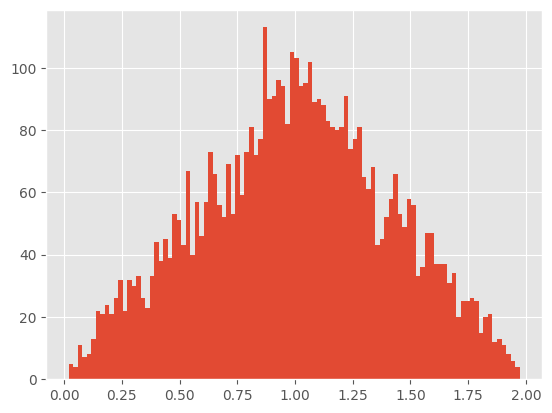

In [17]:
N = 5000 # размер изначальной выборки
X = np.random.uniform(0, 1, size=N) + np.random.uniform(0, 1, size=N)
plt.hist(X, bins=100);

Это распределение называют треугольным, так как его плотность распределения выглядит как треугольник. Вобьём его функцию распределения. Её можно найти в аналитическом виде. Она будет выглядеть вот так: 

In [18]:
def TrueTriangularDistrubition(x):
    if x < 0:
        return 0
    elif x < 1:
        return x**2 / 2
    elif x < 2:
        return 2*x - x**2 / 2 - 1
    else:
        return 1

Давайте сделаем $B=800$ бутсрап-выборок и для каждой из них построим эмпирическую функцию распределения. На этом же графике нарисуем исходную эмпирическую функцию распределения и теоретическую функцию распределения. 

In [19]:
N = 300 # размер изначальной выборки
B = 800 # размер бутстрепной выборки

x = np.random.uniform(0, 1, size=N) + np.random.uniform(0, 1, size=N)
Xb = get_bootstrap_sample(x, B_sample=B)
Xb.shape

(300, 800)

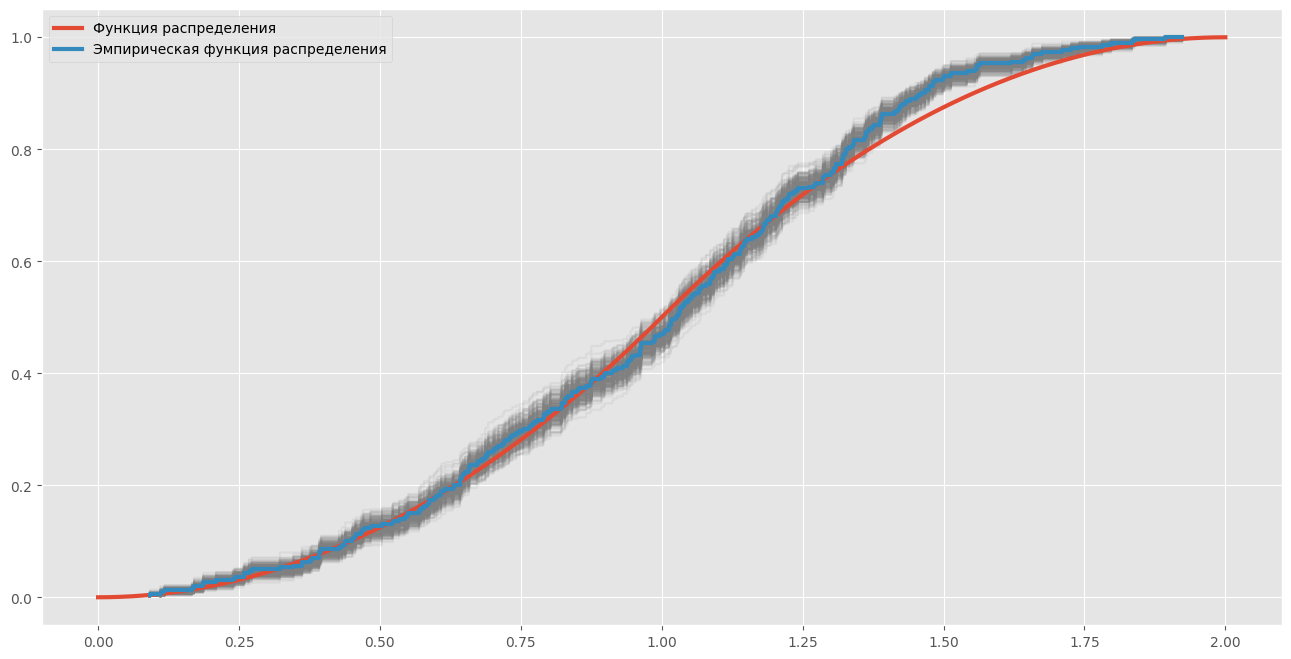

In [20]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

from statsmodels.distributions.empirical_distribution import ECDF

plt.figure(figsize = (16, 8))

# CDF для каждого бутстрепной выборки
for bootstrap_sample in Xb:
    ### BEGIN SOLUTION
    ecdf = ECDF(bootstrap_sample)
    plt.step(ecdf.x, ecdf.y, alpha = 0.1, color='grey')
    ### END SOLUTION
    
# Настоящая функция распределения
xs = np.linspace(0, 2, 100)
cdf = [TrueTriangularDistrubition(item) for item in xs]
plt.plot(xs, cdf, lw = 3, label='Функция распределения')

# эмпирическая функция распределения 
### BEGIN SOLUTION
ecdf = ECDF(x)
plt.step(ecdf.x, ecdf.y, lw = 3, label='Эмпирическая функция распределения')
### END SOLUTION

plt.legend();

Мы не знаем теоретической функции распределения на практике. Мы используем эмпирическую функцию распределения, как бутсрап-аналог для реальности. Мы делаем вид, что у нас есть вся генеральная совокупность, а симуляции это наши независимые наблюдения из неё. 

По картинке видно, что все наши бустрап-выборки вытягиваются именно вдоль эмпирической функции, а не вдоль теоретической. __Мы действуем в предпосылке, что наша выборка хорошо описывает генеральную совокупность.__ Если это не так, мы будем получать неверные выводы.

Посмотрим на то, насколько хорошо, в среднем, бустраповыские эмпирические функции распределения, приближают наше исходное, теоретическое, распределение, при разных значениях $B$ (число бутсрап-выборок размера $N$).  

In [21]:
bins = np.linspace(0, 2, N)

# Настоящее распределение
true_distr = np.array([TrueTriangularDistrubition(item) for item in np.linspace(0, 2, N - 1)])

# диапазон количества испытаний для которых будем смотреть на зависимость
Bs = np.arange(1, 1000, 1)

means = []

for B in tqdm(Bs):
    # бутстрап выборки
    Xb = np.random.choice(x, (B, N), replace=True)
    
    cdfs = []
    for bootstrap_sample in Xb:
        
        # считаем насколько сильно CDF полученная бутстрапом отличается от настоящей
        # bins - те точки, где нам надо считать значения CDF, для удобства они всегда фиксированы
        # мы сначала находим гистограмму, а потом считаем по ней кумулятивную сумму, получается ECDF
        
        cdfs.append(
            true_distr - np.cumsum(np.histogram(bootstrap_sample, bins=bins)[0] / N)
        )
    # считаем среднее отличие по всем B функциям в каждой точке
    means.append(np.array(cdfs).mean(axis=0))

100%|█████████████████████████████████████████| 999/999 [00:20<00:00, 47.68it/s]


Внутри вектора `means` записана средняя разница между бустрап-распределениями и теоретической функцией при разных $B$.

In [22]:
means = np.array(means)
means.shape

(999, 299)

Чем больше $B$, тем меньше должна быть эта разница. Тем не менее, объём исходной выборки, $N$, ограничен. То есть рано или поздно мы должны исчерпать повышение качества за счёт увелечиня $B$.

In [23]:
r = means.mean(axis=1) # усредним разницу по всем бинам
r.shape

(999,)

Если построить график средней ошибки, можно увидеть, что её дисперсия с ростом $B$ становится всё меньше. 

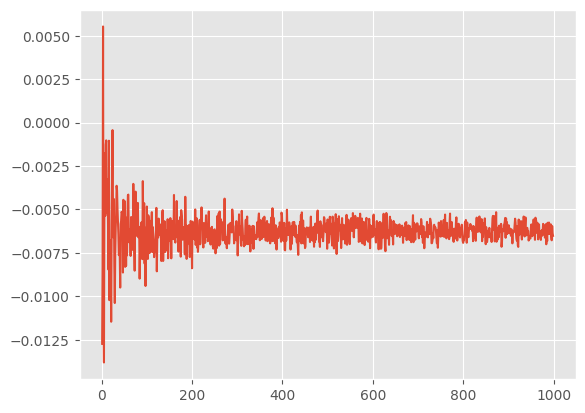

In [24]:
plt.plot(Bs[:len(r)], r);

Вопрос в том, как именно себя эта дисперсия ведёт. Давайте сгладим ёё. Для этого пройдёмся по полученному вектору ошибок скользящим окном. 

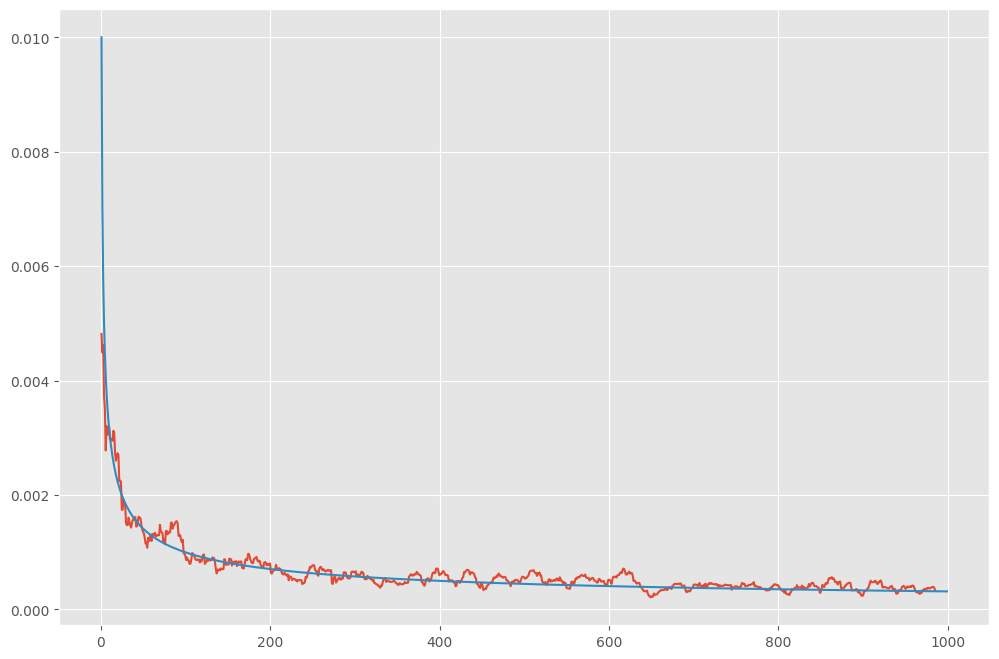

In [25]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

# считаем скользящее стандартное отклонение, чтобы получить более гладкий график
r = np.std(rolling_window(r, 15), -1)

plt.figure(figsize=(12, 8))
plt.plot(Bs[:len(r)], r)
plt.plot(Bs, 1e-2 / np.sqrt(Bs));

### Что мы видим? 

Мы видим, что ошибка постепенно уменьшается. Её стандартное отклонение падает. Причём оно падает как $\frac{1}{\sqrt{n}}$. Эта функция нанесена на картинку синим цветом. На практике для бутсрапа рекомендуется использовать размер бутстрепной выборки порядка $10000$ и больше.